<a href="https://colab.research.google.com/github/Pratham34/Bitcoin_price_prediction_using_time_series_forecasting/blob/main/Bitcoin_price_prediction_using_time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bitcoin price prediction

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.

## Get data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin, we downloaded the data from here: https://www.coindesk.com/price/bitcoin

## Importing time series data with pandas

In [ ]:
import tensorflow as tf
tf.__version__

'2.11.0'

In [ ]:
import pandas as pd

df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"], # parse the date column and tell pandas column 1 is a datetime
                 index_col=["Date"])

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [ ]:
# How many samples ?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples (where lots and lots and lots , can be thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time series data problems.

> Note: The seasonality of a time series dataset is referred to as the number of samples per year. So for our Bitcoin data, it has a seaonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.

In [ ]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


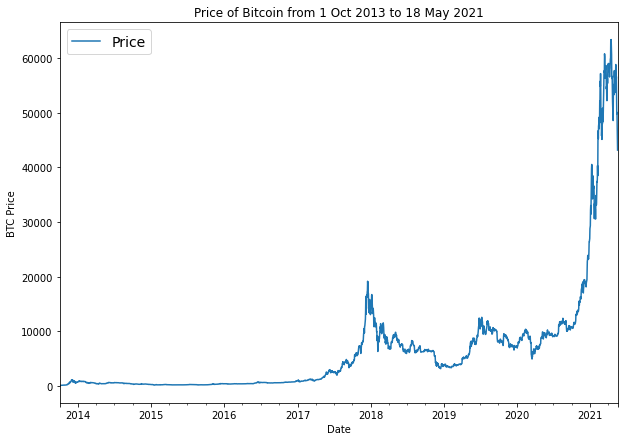

In [ ]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021")
plt.legend(fontsize=14)

## Importing time series data with Python's CSV Module

In [ ]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv","r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_price.append(float(line[2]))  # get the closinng price as float

# View first 10 of each
timesteps[:10] , btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

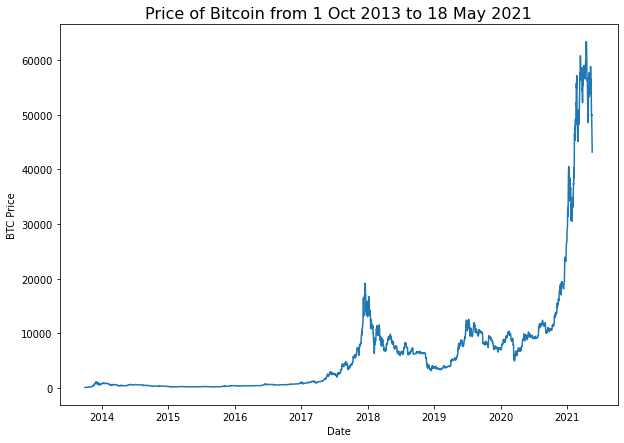

In [ ]:
# Plot from CSV
import matplotlib.pyplot as plt
# import numpy as np
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date");

## Format data part 1 : Create train and test sets of our time series data

In [ ]:
bitcoin_prices[:5]

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10] , prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

## Creating train and test sets for time series

In [ ]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices))  # 80 % train , 20% test

X_train , y_train = timesteps[:split_size] , prices[:split_size]

X_test , y_test = timesteps[split_size:] , prices[split_size:]

len(X_train) , len(X_test) , len(y_train) , len(y_test)

(2229, 558, 2229, 558)

In [ ]:
y_train.shape

(2229,)

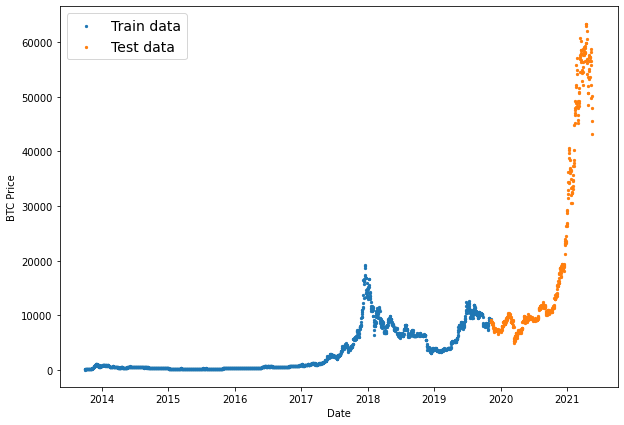

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test , s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Create a plotting function

Typing plotting code is tedious, let's functionize it.

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format="." , start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ----------
  timesteps : array of timestep values
  values : array of values across time
  format : style of plot, default "." ( "." means scatter )
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (similar to start but for the end)
  label : label to show on plot about values, default None
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)  # make label bigger
  plt.grid(True)

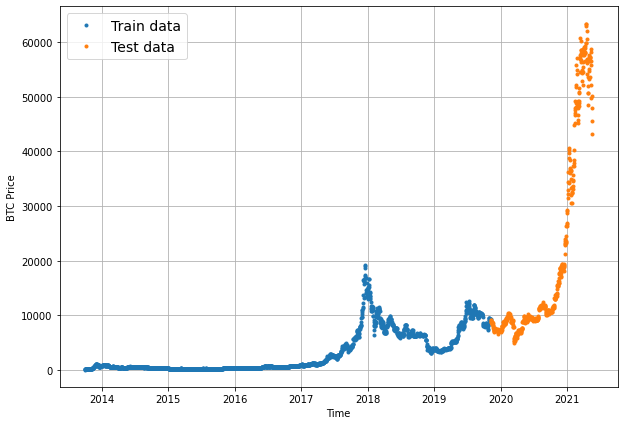

In [ ]:
# Test out the plotting function (We create a figure , then we add both these plots to this figure)
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train ,label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

These are hyperparameters which we can tune

* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict horizon

Modelling experiments we're running:

0. Naïve model (baseline)
1. Dense model, horizon = 1, window = 7
2. Same as 1, horizon = 1, window = 30
3. Same as 1, horizon = 7, window = 30
4. Conv1D
5. LSTM
6. Same as 1 (but with multivariate data)
7. N-BEATs Algorithm
8. Ensemble (multiple models optimized on different loss functions)
9. Future prediction model (model to predict future values)
10. Same as 1 (but with turkey 🦃 data introduced)

## Model 0: Naive forecast (baseline)
The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [ ]:
y_test[:10]

array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
       8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
       8500.64355816, 8469.2608989 ])

In [ ]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10] , naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

In [ ]:
y_test[-10:]

array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
       52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
       45604.61575361, 43144.47129086])

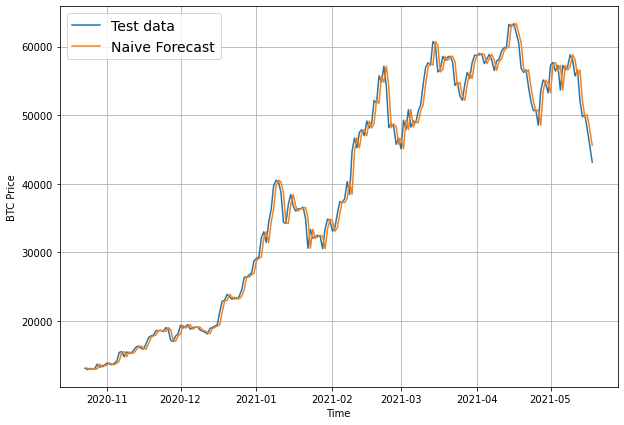

In [ ]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=X_train, values=y_train ,label="Train data")
plot_time_series(timesteps=X_test, values=y_test, start=350 ,format="-",label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast,start=350, format="-",label="Naive Forecast")

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing?

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):

* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean square error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all of the above metrics, **lower is better** , for example, an MAE of 0 that is better than an MAE of 100.

The main thing we're evaluating here is: **how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?**

In [ ]:
import tensorflow as tf

In [ ]:
# MASE implementation

def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data)
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))  # our seasonality is 1 day (hence the shift of 1)  -> (seasonality is 1 day , bcoz bitcoin data is recorded 1 value per day)

  return mae / mae_naive_no_season

In [ ]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

In [ ]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)


  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

That's one good looking evaluation function!

Let's now see if it works...

In [ ]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)

naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [ ]:
naive_forecast[-10:]

array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
       56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
       47885.62525472, 45604.61575361])

In [ ]:
# by looking at mae , We can say that price is 568 off per prediction on average

In [ ]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=20056.632963737222>

In [ ]:
# On average the btc price is 20000 $ !!

In [ ]:
tf.reduce_min(y_test) , tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>,
 <tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>)

## Format Data Part 2: Windowing our dataset
Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [ ]:
len(y_train)

2229

In [ ]:
btc_price[:8]

[123.65499,
 125.455,
 108.58483,
 118.67466,
 121.33866,
 120.65533,
 121.795,
 123.033]

```
[[window_1],
 [window_2],
 [window_3]...]
 ```

In [ ]:
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [ ]:
# seting up global variables for window and horizon size
HORIZON = 1  # predict next 1 day
WINDOW_SIZE = 7  # use the past week of Bitcoin data to make the prediction

In [ ]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# Test out the window labelling function
test_window , test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
# test_window , test_label

print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


In [ ]:
btc_price[:20]

[123.65499,
 125.455,
 108.58483,
 118.67466,
 121.33866,
 120.65533,
 121.795,
 123.033,
 124.049,
 125.96116,
 125.27966,
 125.9275,
 126.38333,
 135.24199,
 133.20333,
 142.76333,
 137.92333,
 142.95166,
 152.55183,
 160.33883]

We've got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above across our entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage NumPy's array indexing

Our function will:

1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon


In [ ]:
import numpy as np

# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon),axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes, window_indexes.shape}")

  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  # print(windowed_array)

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [ ]:
# Rough work for just understanding the above function
window_size=WINDOW_SIZE
horizon=HORIZON

# np.expand_dims(np.arange(window_size+horizon),axis=0)
# np.expand_dims(np.arange(len(prices)-(window_size+horizon-1)), axis=0).T
np.expand_dims(np.arange(window_size+horizon),axis=0) + np.expand_dims(np.arange(len(prices)-(window_size+horizon-1)), axis=0).T

array([[   0,    1,    2, ...,    5,    6,    7],
       [   1,    2,    3, ...,    6,    7,    8],
       [   2,    3,    4, ...,    7,    8,    9],
       ...,
       [2777, 2778, 2779, ..., 2782, 2783, 2784],
       [2778, 2779, 2780, ..., 2783, 2784, 2785],
       [2779, 2780, 2781, ..., 2784, 2785, 2786]])

In [ ]:
len(prices)

2787

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
full_windows

array([[  123.65499   ,   125.455     ,   108.58483   , ...,
          121.33866   ,   120.65533   ,   121.795     ],
       [  125.455     ,   108.58483   ,   118.67466   , ...,
          120.65533   ,   121.795     ,   123.033     ],
       [  108.58483   ,   118.67466   ,   121.33866   , ...,
          121.795     ,   123.033     ,   124.049     ],
       ...,
       [58788.20967893, 58102.19142623, 55715.54665129, ...,
        52147.82118698, 49764.1320816 , 50032.69313676],
       [58102.19142623, 55715.54665129, 56573.5554719 , ...,
        49764.1320816 , 50032.69313676, 47885.62525472],
       [55715.54665129, 56573.5554719 , 52147.82118698, ...,
        50032.69313676, 47885.62525472, 45604.61575361]])

In [ ]:
len(prices)

2787

In [ ]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [ ]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


## Turning windows into training and test sets

In [ ]:
full_windows[:5] , full_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [ ]:
0.2 * len(full_windows)

556.0

In [ ]:
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split))  # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows , test_windows , train_labels , test_labels

In [ ]:
# Create train and test windows
train_windows , test_windows , train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows) , len(test_windows) , len(train_labels) , len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
len(full_windows) * 0.8

2224.0

In [ ]:
train_windows[:5] , train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [ ]:
test_windows[:5] , test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [ ]:
# train_labels[:5]
# train_labels.shape
# np.squeeze(train_labels[:5])
# np.squeeze(train_labels).shape

In [ ]:
np.squeeze(train_labels)

array([ 123.033     ,  124.049     ,  125.96116   , ..., 9335.75240233,
       9226.48582088, 8794.35864452])

In [ ]:
y_train

array([ 123.65499   ,  125.455     ,  108.58483   , ..., 9369.62808116,
       9326.59962378, 9335.75240233])

In [ ]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

In [ ]:
train_labels[:-HORIZON-1], y_train[WINDOW_SIZE:]

(array([[ 123.033     ],
        [ 124.049     ],
        [ 125.96116   ],
        ...,
        [9369.62808116],
        [9326.59962378],
        [9335.75240233]]),
 array([ 123.033     ,  124.049     ,  125.96116   , ..., 9369.62808116,
        9326.59962378, 9335.75240233]))

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

In [ ]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor="val_loss",
                                            verbose=0,  # only output a limited amount of text)
                                            save_best_only=True)

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:

* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizaiton and MAE loss function
* Batch size of 128 (previously we've used 32)
* 100 epochs

Why these values?

I picked them out of experimentation.

* Hyperparameters = values a machine learning practitioner (you!) can adjust themselves
* Parameters = values a model learns on its own

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")  # linear activation is the same as having no activation
], name="model_1_dense")  # name our model so we can save it

# 2. Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 1:18 - loss: 3433.7490 - mae: 3433.7490 - mse: 24225106.0000

18/18 [==============================] - 5s 43ms/step - loss: 1396.7748 - mae: 1396.7748 - mse: 7034755.5000 - val_loss: 2858.8442 - val_mae: 2858.8445 - val_mse: 18446516.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 424.6061 - mae: 424.6061 - mse: 789257.8750

18/18 [==============================] - 0s 26ms/step - loss: 348.5621 - mae: 348.5621 - mse: 487786.0625 - val_loss: 1429.8188 - val_mae: 1429.8188 - val_mse: 5200332.0000
Epoch 3/100
16/18 [=========================>....] - ETA: 0s - loss: 198.6464 - mae: 198.6464 - mse: 191313.5781

18/18 [==============================] - 1s 38ms/step - loss: 196.5638 - mae: 196.5638 - mse: 190850.7031 - val_loss: 1173.7578 - val_mae: 1173.7578 - val_mse: 3877347.5000
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 230.8744 - mae: 230.8744 - mse: 221211.1094

18/18 [==============================] - 0s 26ms/step - loss: 181.0899 - mae: 181.0899 - mse: 172427.0938 - val_loss: 973.6631 - val_mae: 973.6631 - val_mse: 3204940.7500
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 185.5142 - mae: 185.5142 - mse: 126647.6406

18/18 [==============================] - 1s 40ms/step - loss: 174.0201 - mae: 174.0201 - mse: 161811.6875 - val_loss: 958.3086 - val_mae: 958.3086 - val_mse: 3021953.5000
Epoch 6/100
11/18 [=================>............] - ETA: 0s - loss: 168.8469 - mae: 168.8469 - mse: 142667.6406

18/18 [==============================] - 1s 57ms/step - loss: 171.7061 - mae: 171.7061 - mse: 155089.4844 - val_loss: 926.1302 - val_mae: 926.1302 - val_mse: 2931991.7500
Epoch 7/100
11/18 [=================>............] - ETA: 0s - loss: 175.4972 - mae: 175.4972 - mse: 167280.0469

18/18 [==============================] - 1s 55ms/step - loss: 164.7960 - mae: 164.7960 - mse: 144148.6250 - val_loss: 921.3228 - val_mae: 921.3228 - val_mse: 2730669.5000
Epoch 8/100
14/18 [======================>.......] - ETA: 0s - loss: 157.1415 - mae: 157.1415 - mse: 135065.5781

18/18 [==============================] - 1s 52ms/step - loss: 158.1433 - mae: 158.1433 - mse: 136998.8906 - val_loss: 864.2670 - val_mae: 864.2670 - val_mse: 2551192.0000
Epoch 9/100
16/18 [=========================>....] - ETA: 0s - loss: 159.8862 - mae: 159.8862 - mse: 137420.5469

18/18 [==============================] - 1s 57ms/step - loss: 156.6645 - mae: 156.6645 - mse: 132071.5469 - val_loss: 850.6528 - val_mae: 850.6528 - val_mse: 2387549.5000
Epoch 10/100
14/18 [======================>.......] - ETA: 0s - loss: 148.9712 - mae: 148.9712 - mse: 118440.5156

18/18 [==============================] - 1s 68ms/step - loss: 152.6082 - mae: 152.6082 - mse: 127445.5938 - val_loss: 819.4356 - val_mae: 819.4356 - val_mse: 2236669.2500
Epoch 11/100
16/18 [=========================>....] - ETA: 0s - loss: 145.1632 - mae: 145.1632 - mse: 116275.5703

18/18 [==============================] - 2s 109ms/step - loss: 146.1540 - mae: 146.1540 - mse: 116781.1562 - val_loss: 807.0411 - val_mae: 807.0411 - val_mse: 2127756.5000
Epoch 12/100
18/18 [==============================] - 0s 14ms/step - loss: 141.4530 - mae: 141.4530 - mse: 111466.0859 - val_loss: 829.2006 - val_mae: 829.2006 - val_mse: 2116279.2500
Epoch 13/100
18/18 [==============================] - 0s 11ms/step - loss: 140.7477 - mae: 140.7477 - mse: 109498.0391 - val_loss: 826.8938 - val_mae: 826.8938 - val_mse: 2069334.7500
Epoch 14/100
13/18 [====================>.........] - ETA: 0s - loss: 133.1865 - mae: 133.1865 - mse: 97317.8594

18/18 [==============================] - 1s 64ms/step - loss: 135.4091 - mae: 135.4091 - mse: 103044.5000 - val_loss: 774.2070 - val_mae: 774.2070 - val_mse: 1895224.6250
Epoch 15/100
12/18 [===================>..........] - ETA: 0s - loss: 132.2032 - mae: 132.2032 - mse: 95184.1641

18/18 [==============================] - 1s 51ms/step - loss: 137.9439 - mae: 137.9439 - mse: 102213.7031 - val_loss: 749.2761 - val_mae: 749.2761 - val_mse: 1793345.3750
Epoch 16/100
13/18 [====================>.........] - ETA: 0s - loss: 130.7767 - mae: 130.7767 - mse: 90845.7344

18/18 [==============================] - 1s 53ms/step - loss: 129.3884 - mae: 129.3884 - mse: 93486.2188 - val_loss: 725.6482 - val_mae: 725.6482 - val_mse: 1702283.8750
Epoch 17/100
18/18 [==============================] - 0s 8ms/step - loss: 126.2404 - mae: 126.2404 - mse: 92778.1719 - val_loss: 728.8507 - val_mae: 728.8507 - val_mse: 1690585.7500
Epoch 18/100
11/18 [=================>............] - ETA: 0s - loss: 129.0299 - mae: 129.0299 - mse: 96740.1797 

18/18 [==============================] - 1s 56ms/step - loss: 125.9497 - mae: 125.9497 - mse: 90015.9688 - val_loss: 673.5464 - val_mae: 673.5464 - val_mse: 1566444.0000
Epoch 19/100
18/18 [==============================] - 0s 10ms/step - loss: 123.6673 - mae: 123.6673 - mse: 89375.8203 - val_loss: 683.1984 - val_mae: 683.1984 - val_mse: 1542785.0000
Epoch 20/100
14/18 [======================>.......] - ETA: 0s - loss: 122.2105 - mae: 122.2105 - mse: 88082.3281 

18/18 [==============================] - 1s 57ms/step - loss: 119.8431 - mae: 119.8431 - mse: 85590.7344 - val_loss: 664.4332 - val_mae: 664.4332 - val_mse: 1488498.5000
Epoch 21/100
13/18 [====================>.........] - ETA: 0s - loss: 121.8103 - mae: 121.8103 - mse: 81043.7812

18/18 [==============================] - 1s 72ms/step - loss: 123.5636 - mae: 123.5636 - mse: 87350.4062 - val_loss: 647.8500 - val_mae: 647.8500 - val_mse: 1462317.6250
Epoch 22/100
18/18 [==============================] - 0s 7ms/step - loss: 121.8271 - mae: 121.8271 - mse: 86272.5000 - val_loss: 660.3857 - val_mae: 660.3857 - val_mse: 1455600.2500
Epoch 23/100
15/18 [========================>.....] - ETA: 0s - loss: 123.7423 - mae: 123.7423 - mse: 82882.7891

18/18 [==============================] - 1s 48ms/step - loss: 122.8267 - mae: 122.8267 - mse: 84784.2266 - val_loss: 634.4739 - val_mae: 634.4739 - val_mse: 1399317.7500
Epoch 24/100
18/18 [==============================] - 0s 10ms/step - loss: 122.1675 - mae: 122.1675 - mse: 85982.6797 - val_loss: 661.8394 - val_mae: 661.8394 - val_mse: 1491505.1250
Epoch 25/100
14/18 [======================>.......] - ETA: 0s - loss: 121.4561 - mae: 121.4561 - mse: 79631.2422

18/18 [==============================] - 2s 92ms/step - loss: 119.5583 - mae: 119.5583 - mse: 81196.3906 - val_loss: 622.6599 - val_mae: 622.6599 - val_mse: 1365141.6250
Epoch 26/100
12/18 [===================>..........] - ETA: 0s - loss: 115.7580 - mae: 115.7580 - mse: 71168.8984

18/18 [==============================] - 1s 87ms/step - loss: 116.8269 - mae: 116.8269 - mse: 80271.7109 - val_loss: 620.3104 - val_mae: 620.3104 - val_mse: 1349126.1250
Epoch 27/100
14/18 [======================>.......] - ETA: 0s - loss: 120.5736 - mae: 120.5736 - mse: 80048.5391

18/18 [==============================] - 1s 86ms/step - loss: 118.9832 - mae: 118.9832 - mse: 80353.6250 - val_loss: 615.7696 - val_mae: 615.7696 - val_mse: 1336811.8750
Epoch 28/100
18/18 [==============================] - 0s 7ms/step - loss: 114.2425 - mae: 114.2425 - mse: 78319.6484 - val_loss: 617.7059 - val_mae: 617.7059 - val_mse: 1345107.7500
Epoch 29/100
18/18 [==============================] - 0s 10ms/step - loss: 113.4578 - mae: 113.4578 - mse: 78031.6953 - val_loss: 651.0486 - val_mae: 651.0486 - val_mse: 1395855.7500
Epoch 30/100
 9/18 [==============>...............] - ETA: 0s - loss: 116.8826 - mae: 116.8826 - mse: 74329.8438

18/18 [==============================] - 1s 52ms/step - loss: 121.9011 - mae: 121.9011 - mse: 82394.7109 - val_loss: 609.9513 - val_mae: 609.9513 - val_mse: 1310466.1250
Epoch 31/100
18/18 [==============================] - 0s 10ms/step - loss: 115.7402 - mae: 115.7402 - mse: 76089.5391 - val_loss: 655.5099 - val_mae: 655.5099 - val_mse: 1399161.5000
Epoch 32/100
11/18 [=================>............] - ETA: 0s - loss: 117.0769 - mae: 117.0769 - mse: 78621.1094

18/18 [==============================] - 1s 57ms/step - loss: 114.4687 - mae: 114.4687 - mse: 79165.7891 - val_loss: 603.0007 - val_mae: 603.0007 - val_mse: 1297318.5000
Epoch 33/100
18/18 [==============================] - 0s 17ms/step - loss: 114.8842 - mae: 114.8842 - mse: 78405.5078 - val_loss: 691.8138 - val_mae: 691.8138 - val_mse: 1479773.7500
Epoch 34/100
18/18 [==============================] - 0s 12ms/step - loss: 114.3842 - mae: 114.3842 - mse: 77579.2188 - val_loss: 613.5565 - val_mae: 613.5565 - val_mse: 1320257.3750
Epoch 35/100
18/18 [==============================] - 0s 10ms/step - loss: 112.8236 - mae: 112.8236 - mse: 77027.0391 - val_loss: 640.4341 - val_mae: 640.4341 - val_mse: 1387566.7500
Epoch 36/100
17/18 [===========================>..] - ETA: 0s - loss: 114.1215 - mae: 114.1215 - mse: 75972.2734 

18/18 [==============================] - 1s 54ms/step - loss: 114.0781 - mae: 114.0781 - mse: 75625.2812 - val_loss: 594.6673 - val_mae: 594.6673 - val_mse: 1266564.5000
Epoch 37/100
17/18 [===========================>..] - ETA: 0s - loss: 110.3886 - mae: 110.3886 - mse: 72055.4609

18/18 [==============================] - 1s 78ms/step - loss: 111.1441 - mae: 111.1441 - mse: 74968.1328 - val_loss: 593.9064 - val_mae: 593.9064 - val_mse: 1266622.1250
Epoch 38/100
18/18 [==============================] - 0s 12ms/step - loss: 113.4754 - mae: 113.4754 - mse: 76035.2344 - val_loss: 603.7291 - val_mae: 603.7291 - val_mse: 1288590.7500
Epoch 39/100
18/18 [==============================] - 0s 14ms/step - loss: 110.4625 - mae: 110.4625 - mse: 74318.9141 - val_loss: 595.2790 - val_mae: 595.2790 - val_mse: 1255621.0000
Epoch 40/100
18/18 [==============================] - 0s 9ms/step - loss: 110.5678 - mae: 110.5678 - mse: 73018.3438 - val_loss: 631.5184 - val_mae: 631.5184 - val_mse: 1349439.2500
Epoch 41/100
18/18 [==============================] - 0s 6ms/step - loss: 111.1429 - mae: 111.1429 - mse: 75000.5312 - val_loss: 610.3546 - val_mae: 610.3546 - val_mse: 1295667.6250
Epoch 42/100
18/18 [==============================] - 0s 4ms/step - loss: 113.9999 - mae: 113.9999 -

18/18 [==============================] - 0s 27ms/step - loss: 114.6855 - mae: 114.6855 - mse: 74906.9922 - val_loss: 582.4988 - val_mae: 582.4988 - val_mse: 1226194.7500
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 116.6332 - mae: 116.6332 - mse: 77500.7578 - val_loss: 665.2599 - val_mae: 665.2599 - val_mse: 1389076.2500
Epoch 48/100
 1/18 [>.............................] - ETA: 0s - loss: 113.6375 - mae: 113.6375 - mse: 67766.0078

18/18 [==============================] - 0s 27ms/step - loss: 110.7112 - mae: 110.7112 - mse: 73523.1172 - val_loss: 578.8693 - val_mae: 578.8693 - val_mse: 1215815.8750
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 110.2354 - mae: 110.2354 - mse: 73286.4609 - val_loss: 648.4645 - val_mae: 648.4645 - val_mse: 1345255.8750
Epoch 50/100
18/18 [==============================] - 0s 4ms/step - loss: 116.5870 - mae: 116.5870 - mse: 76091.0234 - val_loss: 587.8895 - val_mae: 587.8895 - val_mse: 1234987.3750
Epoch 51/100
18/18 [==============================] - 0s 6ms/step - loss: 109.5725 - mae: 109.5725 - mse: 71936.6797 - val_loss: 588.5699 - val_mae: 588.5699 - val_mse: 1221773.5000
Epoch 52/100
18/18 [==============================] - 0s 5ms/step - loss: 111.1245 - mae: 111.1245 - mse: 74087.0391 - val_loss: 580.8157 - val_mae: 580.8157 - val_mse: 1208454.0000
Epoch 53/100
18/18 [==============================] - 0s 4ms/step - loss: 111.8505 - mae: 111.8505 - m

18/18 [==============================] - 0s 28ms/step - loss: 112.0918 - mae: 112.0918 - mse: 73372.3906 - val_loss: 574.0572 - val_mae: 574.0572 - val_mse: 1199011.1250
Epoch 60/100
 1/18 [>.............................] - ETA: 0s - loss: 89.9568 - mae: 89.9568 - mse: 35939.7422

18/18 [==============================] - 0s 26ms/step - loss: 108.0619 - mae: 108.0619 - mse: 70773.4766 - val_loss: 573.8577 - val_mae: 573.8577 - val_mse: 1195555.2500
Epoch 61/100
18/18 [==============================] - 0s 5ms/step - loss: 108.2085 - mae: 108.2085 - mse: 71278.1094 - val_loss: 591.0517 - val_mae: 591.0517 - val_mse: 1218666.7500
Epoch 62/100
18/18 [==============================] - 0s 5ms/step - loss: 109.4113 - mae: 109.4113 - mse: 71531.7891 - val_loss: 581.2844 - val_mae: 581.2844 - val_mse: 1211868.5000
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 108.9367 - mae: 108.9367 - mse: 71441.4844 - val_loss: 599.4000 - val_mae: 599.4000 - val_mse: 1233186.3750
Epoch 64/100
12/18 [===================>..........] - ETA: 0s - loss: 113.1535 - mae: 113.1535 - mse: 73505.7578

18/18 [==============================] - 1s 41ms/step - loss: 110.1814 - mae: 110.1814 - mse: 71638.2031 - val_loss: 572.8480 - val_mae: 572.8480 - val_mse: 1193005.7500
Epoch 65/100
18/18 [==============================] - 0s 7ms/step - loss: 108.1449 - mae: 108.1449 - mse: 71087.6094 - val_loss: 587.9370 - val_mae: 587.9370 - val_mse: 1210320.7500
Epoch 66/100
18/18 [==============================] - 0s 7ms/step - loss: 108.9679 - mae: 108.9679 - mse: 71074.1484 - val_loss: 581.9518 - val_mae: 581.9518 - val_mse: 1199025.2500
Epoch 67/100
18/18 [==============================] - 0s 7ms/step - loss: 108.2279 - mae: 108.2279 - mse: 70462.0078 - val_loss: 690.4287 - val_mae: 690.4287 - val_mse: 1475863.0000
Epoch 68/100
18/18 [==============================] - 0s 7ms/step - loss: 112.2493 - mae: 112.2493 - mse: 69654.0469 - val_loss: 685.2568 - val_mae: 685.2568 - val_mse: 1457903.0000
Epoch 69/100
18/18 [==============================] - 0s 6ms/step - loss: 127.6057 - mae: 127.6057 - m

18/18 [==============================] - 1s 33ms/step - loss: 108.2272 - mae: 108.2272 - mse: 70299.5312 - val_loss: 569.4647 - val_mae: 569.4647 - val_mse: 1176989.5000
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 110.9295 - mae: 110.9295 - mse: 72458.0938 - val_loss: 593.9950 - val_mae: 593.9950 - val_mse: 1226937.0000
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 108.0959 - mae: 108.0959 - mse: 71145.7031 - val_loss: 572.6221 - val_mae: 572.6221 - val_mse: 1180611.8750
Epoch 76/100
18/18 [==============================] - 0s 5ms/step - loss: 108.9977 - mae: 108.9977 - mse: 70641.0234 - val_loss: 585.1999 - val_mae: 585.1999 - val_mse: 1199398.5000
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 110.4277 - mae: 110.4277 - mse: 71355.7344 - val_loss: 594.5640 - val_mae: 594.5640 - val_mse: 1228446.7500
Epoch 78/100
18/18 [==============================] - 0s 4ms/step - loss: 107.8852 - mae: 107.8852 - m

18/18 [==============================] - 0s 26ms/step - loss: 106.9594 - mae: 106.9594 - mse: 69925.2500 - val_loss: 567.7312 - val_mae: 567.7312 - val_mse: 1169194.7500
Epoch 82/100
18/18 [==============================] - 0s 4ms/step - loss: 117.7518 - mae: 117.7518 - mse: 77908.9375 - val_loss: 567.8525 - val_mae: 567.8525 - val_mse: 1169050.6250
Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 112.3139 - mae: 112.3139 - mse: 73436.6172 - val_loss: 670.6076 - val_mae: 670.6076 - val_mse: 1409234.0000
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 113.5608 - mae: 113.5608 - mse: 72383.9609 - val_loss: 605.0433 - val_mae: 605.0433 - val_mse: 1248687.6250
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 108.2725 - mae: 108.2725 - mse: 70072.7578 - val_loss: 621.1752 - val_mae: 621.1752 - val_mse: 1272344.8750
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 108.8618 - mae: 108.8618 - m

18/18 [==============================] - 1s 41ms/step - loss: 107.7141 - mae: 107.7141 - mse: 70233.0078 - val_loss: 567.2157 - val_mae: 567.2157 - val_mse: 1166322.1250
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 112.4624 - mae: 112.4624 - mse: 73328.7656 - val_loss: 614.9689 - val_mae: 614.9689 - val_mse: 1267217.3750
Epoch 93/100
18/18 [==============================] - 0s 5ms/step - loss: 121.0600 - mae: 121.0600 - mse: 77588.0156 - val_loss: 664.9515 - val_mae: 664.9515 - val_mse: 1394471.3750
Epoch 94/100
18/18 [==============================] - 0s 6ms/step - loss: 113.2906 - mae: 113.2906 - mse: 74045.5234 - val_loss: 606.5963 - val_mae: 606.5963 - val_mse: 1237647.8750
Epoch 95/100
18/18 [==============================] - 0s 5ms/step - loss: 106.0155 - mae: 106.0155 - mse: 67587.6875 - val_loss: 577.8904 - val_mae: 577.8904 - val_mse: 1186396.1250
Epoch 96/100
18/18 [==============================] - 0s 5ms/step - loss: 106.1187 - mae: 106.1187 - m

18/18 [==============================] - 0s 28ms/step - loss: 106.1131 - mae: 106.1131 - mse: 69450.3047 - val_loss: 566.1268 - val_mae: 566.1268 - val_mse: 1163180.6250
Epoch 99/100
18/18 [==============================] - 0s 5ms/step - loss: 109.5417 - mae: 109.5417 - mse: 71432.7344 - val_loss: 573.9789 - val_mae: 573.9789 - val_mse: 1178306.2500
Epoch 100/100
18/18 [==============================] - 0s 6ms/step - loss: 118.5376 - mae: 118.5376 - mse: 73128.7500 - val_loss: 719.9336 - val_mae: 719.9336 - val_mse: 1506122.2500


In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [ ]:
# Evaluate model on test data  -> (If we hadnt done the ModelCheckpoint step , then we would be getting model predictions with the results it got here in this cell , slightly worse than the best performing model)
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 719.9337 - mae: 719.9337 - mse: 1506122.5000


[719.9336547851562, 719.9336547851562, 1506122.5]

In [ ]:
# Load in saved best performing model_1 and evaluate it on test data [We've reloaded in the best performing model_1 , thanks to our ModelCheckpoint callback] -> so model_1 will now be saved here with the best performing weights
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 566.1267 - mae: 566.1267 - mse: 1163180.2500


[566.126708984375, 566.126708984375, 1163180.25]

## Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only psuedo forecasts because actual forecasts are into the future), let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's predict() method
4. Returns the predictions

In [ ]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)  # return 1D array of predictions

In [ ]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds) , model_1_preds[:10]

18/18 [==============================] - 0s 1ms/step


(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8847.492, 8769.746, 9034.614, 8798.56 , 8739.802, 8745.046,
        8670.886, 8536.667, 8452.937, 8527.468], dtype=float32)>)

In [ ]:
tf.squeeze(test_labels).shape , model_1_preds.shape

(TensorShape([556]), TensorShape([556]))

In [ ]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 566.12665,
 'mse': 1163180.2,
 'rmse': 1078.5083,
 'mape': 2.5398948,
 'mase': 0.9945277}

In [ ]:
test_labels.shape

(556, 1)

In [ ]:
# Not taking test_windows directly , bcoz that wouldnt look good on our graph

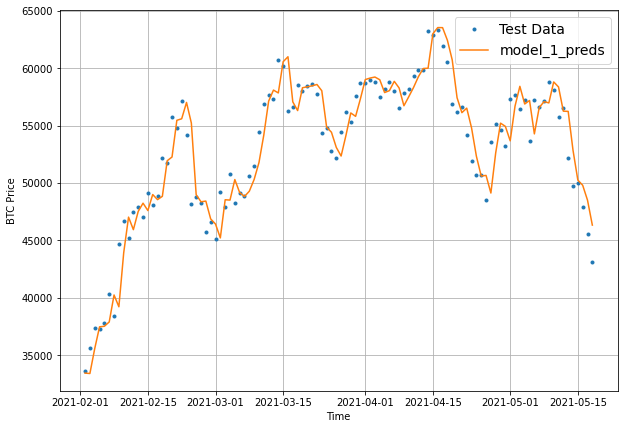

In [ ]:
# Let's plot our model_1 predictions
offset = 450
plt.figure(figsize=(10,7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:,0],
                 start=offset,
                 label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset,
                 format="-",
                 label="model_1_preds")

## Model 2: Dense (window=30 , horizon=1)

In [ ]:
HORIZON = 1 # predict one step at a time (one day of Bitcoin prices)
WINDOW_SIZE = 30 # use 30 timesteps in past

In [ ]:
# Make windowed data with appropriate horizon and window sizes
full_windows , full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows) , len(full_labels)

(2757, 2757)

In [ ]:
# Make train and testing windows
train_windows , test_windows , train_labels , test_labels = make_train_test_splits(windows=full_windows,
                                                                                    labels=full_labels,
                                                                                    test_split=0.2)
len(train_windows) , len(test_windows) , len(train_labels) , len(test_labels)

(2205, 552, 2205, 552)

In [ ]:
train_windows[:3], train_labels[:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 137.92333, 142.95166, 152.55183, 160.33883,
         164.31499, 177

In [ ]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_2_dense")

# Compile
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="mae")

# Fit
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [ ]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 614.9636 - mae: 614.9636


[614.963623046875, 614.963623046875]

In [ ]:
# Load in the best performing model
model_2 = tf.keras.models.load_model("/content/model_experiments/model_2_dense/")
model_2.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 614.9636 - mae: 614.9636


[614.963623046875, 614.963623046875]

In [ ]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 2ms/step


In [ ]:
model_2_preds.shape , test_labels.shape

(TensorShape([552]), (552, 1))

In [ ]:
tf.squeeze(test_labels).shape

TensorShape([552])

In [ ]:
# Evaluate results for model_2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                   y_pred=model_2_preds)
model_2_results

{'mae': 614.9636,
 'mse': 1314869.8,
 'rmse': 1146.6776,
 'mape': 2.753809,
 'mase': 1.0749625}

In [ ]:
model_1_results

{'mae': 566.12665,
 'mse': 1163180.2,
 'rmse': 1078.5083,
 'mape': 2.5398948,
 'mase': 0.9945277}

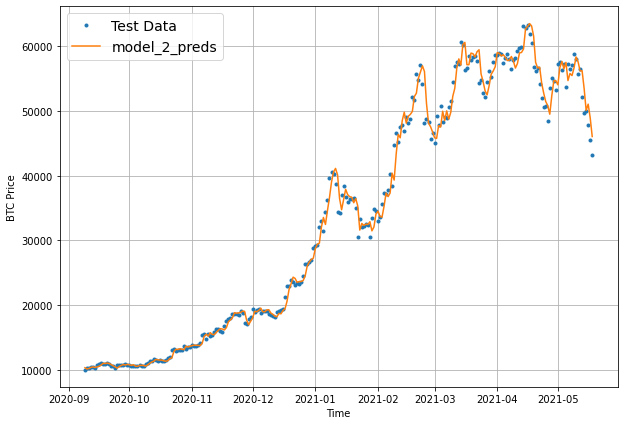

In [ ]:
offset = 300  # (so that our plot is little zoomed in)
plt.figure(figsize=(10,7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3: Dense (window = 30, horizon = 7)

In [ ]:
prices[:10]

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  , 123.033  , 124.049  , 125.96116])

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows , full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows) , len(full_labels)

(2751, 2751)

In [ ]:
train_windows , test_windows , train_labels , test_labels = make_train_test_splits(windows=full_windows,
                                                                                   labels=full_labels)
len(train_labels) , len(test_windows) , len(train_labels) , len(test_labels)

(2200, 551, 2200, 551)

In [ ]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input and output sizes)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

# Compile
model_3.compile(loss="MAE",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [ ]:
# In model_experiments folder , we now have the checkpoints of the best performing model

In [ ]:
# Evaluate the model on the test data
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1421.0010


1421.0009765625

In [ ]:
# Load best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense")
model_3.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1242.7595


1242.759521484375

In [ ]:
# Make predictions with model_3
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9291.385 , 9458.471 , 9660.991 , 9604.549 , 9487.33  , 9551.279 ,
        9551.01  ],
       [8960.974 , 9070.995 , 9157.305 , 9389.601 , 9180.377 , 9173.918 ,
        9251.796 ],
       [8778.713 , 8837.17  , 9080.819 , 9110.756 , 9086.619 , 9121.561 ,
        8909.89  ],
       [8884.748 , 9079.473 , 9224.412 , 9239.025 , 9393.695 , 9347.568 ,
        9021.329 ],
       [8798.41  , 9082.651 , 9215.186 , 8985.446 , 9190.8125, 9212.51  ,
        8818.623 ]], dtype=float32)>

In [ ]:
model_2_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8743.998, 8848.309, 8828.306, 8634.379, 8486.21 ], dtype=float32)>

In [ ]:
model_2_results

{'mae': 614.9636,
 'mse': 1314869.8,
 'rmse': 1146.6776,
 'mape': 2.753809,
 'mase': 1.0749625}

In [ ]:
model_3_preds.shape , model_2_preds.shape , model_1_preds.shape

(TensorShape([551, 7]), TensorShape([552]), TensorShape([556]))

In [ ]:
# Evaluate model_3 results
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                y_pred=model_3_preds)
model_3_results

{'mae': array([  721.7871  ,   420.9368  ,   371.49512 ,   543.4413  ,
          489.02914 ,   502.9105  ,   542.26715 ,   550.9967  ,
          528.3038  ,   627.74554 ,   907.0236  ,   841.8163  ,
          875.3763  ,   964.50726 ,   652.7676  ,   277.06265 ,
          209.82275 ,   211.12967 ,   238.6031  ,   220.58621 ,
          200.85701 ,   230.42773 ,   358.07367 ,   437.15005 ,
          233.66832 ,   153.25754 ,   137.92732 ,   137.1273  ,
          167.57555 ,   296.06363 ,   363.18256 ,   392.3616  ,
          437.3646  ,   428.482   ,   326.24908 ,   337.81766 ,
          391.06934 ,   277.09103 ,   200.72488 ,   157.80846 ,
          425.8107  ,    50.446846,   119.47133 ,    85.57833 ,
          174.00237 ,   183.8344  ,   127.63239 ,    85.956894,
          174.76234 ,   109.96094 ,   168.3849  ,   270.68442 ,
          257.58902 ,   199.19727 ,   247.89133 ,   299.56326 ,
          522.32526 ,   412.45355 ,   415.9637  ,   507.14893 ,
          313.52756 ,   185.20451

## Make our evaluation function work for larger horizons

In [ ]:
# model_3_results["mae"].shape
model_3_results["mae"].ndim

1

In [ ]:
# model_2_results["mae"].shape
model_2_results["mae"].ndim

0

In [ ]:
tf.reduce_mean(model_3_results["mae"]).numpy()

1242.7595

In [ ]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
model_3.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1242.7595


1242.759521484375

In [ ]:
tf.reduce_mean(model_3_results["mae"]).numpy()

1242.7595

In [ ]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1242.7595,
 'mse': 5476694.0,
 'rmse': 1430.5488,
 'mape': 5.6228805,
 'mase': 2.211421}

In [ ]:
model_1_results , model_2_results , naive_results

({'mae': 566.12665,
  'mse': 1163180.2,
  'rmse': 1078.5083,
  'mape': 2.5398948,
  'mase': 0.9945277},
 {'mae': 614.9636,
  'mse': 1314869.8,
  'rmse': 1146.6776,
  'mape': 2.753809,
  'mase': 1.0749625},
 {'mae': 567.9802,
  'mse': 1147547.0,
  'rmse': 1071.2362,
  'mape': 2.516525,
  'mase': 0.99957})

Time to visualize.

If our prediction evaluation metrics were mutli-dimensional, how do you think the predictions will look like if we plot them?

In [ ]:
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9291.385 , 9458.471 , 9660.991 , 9604.549 , 9487.33  , 9551.279 ,
        9551.01  ],
       [8960.974 , 9070.995 , 9157.305 , 9389.601 , 9180.377 , 9173.918 ,
        9251.796 ],
       [8778.713 , 8837.17  , 9080.819 , 9110.756 , 9086.619 , 9121.561 ,
        8909.89  ],
       [8884.748 , 9079.473 , 9224.412 , 9239.025 , 9393.695 , 9347.568 ,
        9021.329 ],
       [8798.41  , 9082.651 , 9215.186 , 8985.446 , 9190.8125, 9212.51  ,
        8818.623 ]], dtype=float32)>

In [ ]:
test_labels[:,0][:5]

array([8794.35864452, 8798.04205463, 9081.18687849, 8711.53433917,
       8760.89271814])

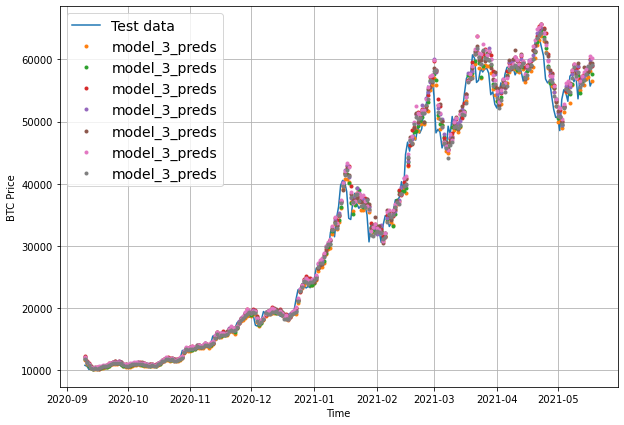

In [ ]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset,format="-", label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

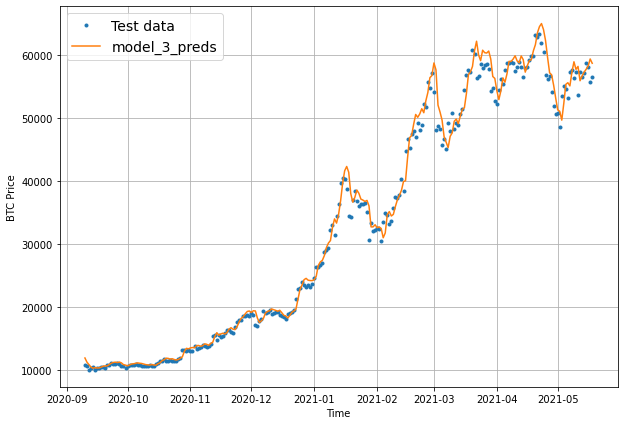

In [ ]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds,axis=1), start=offset, format="-",label="model_3_preds")

In [ ]:
model_3_preds[0]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([9291.385, 9458.471, 9660.991, 9604.549, 9487.33 , 9551.279,
       9551.01 ], dtype=float32)>

In [ ]:
tf.reduce_mean(model_3_preds[0])

<tf.Tensor: shape=(), dtype=float32, numpy=9515.002>

## Which of our models is performing the best so far ?

So we've trained a few models , now let's compare them and see how they've gone...

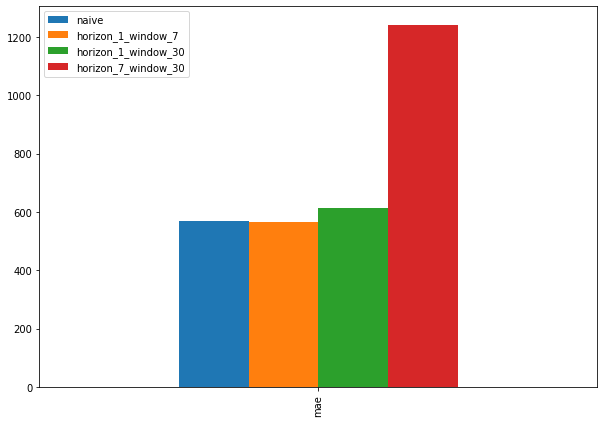

In [ ]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10,7), kind="bar");

## Model 4: Conv1D

In [ ]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7 # use previous week worth data

In [ ]:
# Create windowed data
full_windows , full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows) , len(full_labels)

(2780, 2780)

In [ ]:
# Create train/test sets
train_windows , test_windows , train_labels , test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows) , len(train_labels) , len(test_windows) , len(test_labels)

(2224, 2224, 556, 556)

To use the Conv1D layer, we need an input shape of: `(batch_size, timesteps, input_dim)` ...

However our data isn't in that shape yet...

In [ ]:
# Check data input shape
train_windows[0].shape  # returns (WINDOW_SIZE, )

(7,)

In [ ]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [ ]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))  # add an extra dimension for `input_dim`

In [ ]:
# Test out our lambda layer
print(f"Original shape: {x.shape}")  # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}")  # output = ...
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [ ]:
tf.random.set_seed(42)

# Create Conv1D model
model_4 = tf.keras.Sequential([
    expand_dims_layer,
    layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 1896.8923  

18/18 [==============================] - 7s 47ms/step - loss: 1896.8923 - val_loss: 2885.1860
Epoch 2/100
13/18 [====================>.........] - ETA: 0s - loss: 308.5863

18/18 [==============================] - 1s 36ms/step - loss: 282.4604 - val_loss: 1167.6703
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 200.5661

18/18 [==============================] - 1s 50ms/step - loss: 200.5661 - val_loss: 950.3329
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 218.7081

18/18 [==============================] - 1s 38ms/step - loss: 172.2302 - val_loss: 943.3784
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 168.6803 - val_loss: 945.8779
Epoch 6/100
18/18 [==============================] - ETA: 0s - loss: 165.8492

18/18 [==============================] - 1s 38ms/step - loss: 165.8492 - val_loss: 923.0466
Epoch 7/100
18/18 [==============================] - ETA: 0s - loss: 164.0647

18/18 [==============================] - 1s 36ms/step - loss: 164.0647 - val_loss: 909.2436
Epoch 8/100
18/18 [==============================] - ETA: 0s - loss: 161.3749

18/18 [==============================] - 1s 37ms/step - loss: 161.3749 - val_loss: 902.5465
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 160.3097 - val_loss: 923.9920
Epoch 10/100
18/18 [==============================] - ETA: 0s - loss: 158.2488

18/18 [==============================] - 1s 47ms/step - loss: 158.2488 - val_loss: 884.7372
Epoch 11/100
12/18 [===================>..........] - ETA: 0s - loss: 164.0972

18/18 [==============================] - 1s 52ms/step - loss: 156.3103 - val_loss: 863.9509
Epoch 12/100
18/18 [==============================] - 0s 8ms/step - loss: 154.3270 - val_loss: 909.7201
Epoch 13/100
13/18 [====================>.........] - ETA: 0s - loss: 149.7502

18/18 [==============================] - 1s 43ms/step - loss: 152.4930 - val_loss: 861.6768
Epoch 14/100
18/18 [==============================] - ETA: 0s - loss: 150.2515

18/18 [==============================] - 1s 36ms/step - loss: 150.2515 - val_loss: 858.3650
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 151.0331

18/18 [==============================] - 1s 35ms/step - loss: 148.6254 - val_loss: 829.5900
Epoch 16/100
18/18 [==============================] - ETA: 0s - loss: 145.7397

18/18 [==============================] - 1s 35ms/step - loss: 145.7397 - val_loss: 811.1640
Epoch 17/100
18/18 [==============================] - 0s 5ms/step - loss: 144.7854 - val_loss: 813.1120
Epoch 18/100
18/18 [==============================] - 0s 5ms/step - loss: 142.6552 - val_loss: 811.6435
Epoch 19/100
18/18 [==============================] - ETA: 0s - loss: 140.2839

18/18 [==============================] - 1s 35ms/step - loss: 140.2839 - val_loss: 793.4840
Epoch 20/100
18/18 [==============================] - 0s 5ms/step - loss: 140.5981 - val_loss: 831.7497
Epoch 21/100
17/18 [===========================>..] - ETA: 0s - loss: 141.2569

18/18 [==============================] - 1s 54ms/step - loss: 142.2248 - val_loss: 758.6814
Epoch 22/100
18/18 [==============================] - ETA: 0s - loss: 136.3655

18/18 [==============================] - 1s 38ms/step - loss: 136.3655 - val_loss: 754.3691
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 146.3082

18/18 [==============================] - 1s 36ms/step - loss: 133.7951 - val_loss: 746.6450
Epoch 24/100
18/18 [==============================] - ETA: 0s - loss: 134.2987

18/18 [==============================] - 1s 36ms/step - loss: 134.2987 - val_loss: 739.6460
Epoch 25/100
18/18 [==============================] - 0s 6ms/step - loss: 134.7542 - val_loss: 745.1451
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 130.7995

18/18 [==============================] - 1s 37ms/step - loss: 129.8018 - val_loss: 715.1566
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 184.8976

18/18 [==============================] - 1s 36ms/step - loss: 128.9941 - val_loss: 707.6331
Epoch 28/100
17/18 [===========================>..] - ETA: 0s - loss: 127.1702

18/18 [==============================] - 1s 37ms/step - loss: 127.0522 - val_loss: 703.1987
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 120.2392

18/18 [==============================] - 1s 37ms/step - loss: 125.8278 - val_loss: 694.1268
Epoch 30/100
18/18 [==============================] - 0s 5ms/step - loss: 128.8154 - val_loss: 791.3144
Epoch 31/100
18/18 [==============================] - 0s 6ms/step - loss: 133.3779 - val_loss: 762.2176
Epoch 32/100
18/18 [==============================] - 0s 5ms/step - loss: 128.7229 - val_loss: 700.9814
Epoch 33/100
 1/18 [>.............................] - ETA: 0s - loss: 152.7015

18/18 [==============================] - 1s 36ms/step - loss: 125.9641 - val_loss: 676.7170
Epoch 34/100
18/18 [==============================] - ETA: 0s - loss: 122.1350

18/18 [==============================] - 1s 38ms/step - loss: 122.1350 - val_loss: 662.9700
Epoch 35/100
12/18 [===================>..........] - ETA: 0s - loss: 122.8355

18/18 [==============================] - 1s 54ms/step - loss: 121.1801 - val_loss: 660.9221
Epoch 36/100
18/18 [==============================] - 0s 8ms/step - loss: 123.5903 - val_loss: 718.8519
Epoch 37/100
13/18 [====================>.........] - ETA: 0s - loss: 122.7336

18/18 [==============================] - 1s 52ms/step - loss: 121.3608 - val_loss: 649.6107
Epoch 38/100
18/18 [==============================] - ETA: 0s - loss: 119.9911

18/18 [==============================] - 1s 56ms/step - loss: 119.9911 - val_loss: 644.7475
Epoch 39/100
18/18 [==============================] - 0s 5ms/step - loss: 120.7737 - val_loss: 702.2455
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 123.4979

18/18 [==============================] - 1s 37ms/step - loss: 119.0040 - val_loss: 639.6971
Epoch 41/100
16/18 [=========================>....] - ETA: 0s - loss: 120.7821

18/18 [==============================] - 1s 36ms/step - loss: 118.7683 - val_loss: 634.1060
Epoch 42/100
 1/18 [>.............................] - ETA: 0s - loss: 113.3848

18/18 [==============================] - 1s 37ms/step - loss: 121.4821 - val_loss: 629.6932
Epoch 43/100
18/18 [==============================] - 0s 6ms/step - loss: 117.7116 - val_loss: 656.1196
Epoch 44/100
18/18 [==============================] - 0s 5ms/step - loss: 119.3072 - val_loss: 632.7341
Epoch 45/100
 1/18 [>.............................] - ETA: 0s - loss: 82.9797

18/18 [==============================] - 1s 36ms/step - loss: 118.2311 - val_loss: 621.9904
Epoch 46/100
18/18 [==============================] - ETA: 0s - loss: 116.3065

18/18 [==============================] - 1s 35ms/step - loss: 116.3065 - val_loss: 618.8843
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 119.4070 - val_loss: 677.2827
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 117.3643 - val_loss: 687.9012
Epoch 49/100
16/18 [=========================>....] - ETA: 0s - loss: 118.4830

18/18 [==============================] - 1s 36ms/step - loss: 119.1249 - val_loss: 614.0714
Epoch 50/100
18/18 [==============================] - ETA: 0s - loss: 114.1985

18/18 [==============================] - 1s 37ms/step - loss: 114.1985 - val_loss: 611.7866
Epoch 51/100
18/18 [==============================] - 0s 6ms/step - loss: 114.3236 - val_loss: 619.2017
Epoch 52/100
 1/18 [>.............................] - ETA: 0s - loss: 123.6356

18/18 [==============================] - 1s 36ms/step - loss: 115.8829 - val_loss: 605.5616
Epoch 53/100
18/18 [==============================] - ETA: 0s - loss: 116.5758

18/18 [==============================] - 1s 36ms/step - loss: 116.5758 - val_loss: 603.8165
Epoch 54/100
18/18 [==============================] - 0s 5ms/step - loss: 113.2704 - val_loss: 626.3559
Epoch 55/100
18/18 [==============================] - 0s 5ms/step - loss: 115.6742 - val_loss: 621.0327
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 116.8692 - val_loss: 748.8492
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 133.6617 - val_loss: 610.8136
Epoch 58/100
18/18 [==============================] - 0s 5ms/step - loss: 119.5550 - val_loss: 611.7508
Epoch 59/100
18/18 [==============================] - 0s 6ms/step - loss: 111.5153 - val_loss: 612.5292
Epoch 60/100
18/18 [==============================] - 0s 6ms/step - loss: 113.0598 - val_loss: 608.2838
Epoch 61/100
18/18 [==============================] - 0s 6ms/step - loss: 112.0512 - val_loss: 606.4717
Epoch 62/100
18/18 [==============================] - ETA: 0s - loss: 111.45

18/18 [==============================] - 1s 35ms/step - loss: 111.4549 - val_loss: 592.2695
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 112.7398 - val_loss: 593.0155
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 112.7027 - val_loss: 685.1932
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 122.3742 - val_loss: 719.7368
Epoch 66/100
18/18 [==============================] - 0s 6ms/step - loss: 115.1791 - val_loss: 623.0228
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 114.7130 - val_loss: 640.6066
Epoch 68/100
18/18 [==============================] - 0s 6ms/step - loss: 117.0059 - val_loss: 646.8497
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 121.8218 - val_loss: 678.7059
Epoch 70/100
18/18 [==============================] - 0s 5ms/step - loss: 120.5125 - val_loss: 604.1668
Epoch 71/100
18/18 [==============================] - 0s 6ms/step - loss: 11

18/18 [==============================] - 1s 69ms/step - loss: 114.4333 - val_loss: 586.0218
Epoch 73/100
18/18 [==============================] - 0s 7ms/step - loss: 109.6618 - val_loss: 586.5397
Epoch 74/100
13/18 [====================>.........] - ETA: 0s - loss: 111.1174

18/18 [==============================] - 2s 106ms/step - loss: 111.1232 - val_loss: 581.4945
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 109.9941 - val_loss: 603.5145
Epoch 76/100
18/18 [==============================] - 0s 17ms/step - loss: 110.8598 - val_loss: 585.4891
Epoch 77/100
18/18 [==============================] - 0s 18ms/step - loss: 112.8509 - val_loss: 581.5653
Epoch 78/100
16/18 [=========================>....] - ETA: 0s - loss: 111.5671

18/18 [==============================] - 1s 53ms/step - loss: 111.0265 - val_loss: 578.7549
Epoch 79/100
18/18 [==============================] - 0s 13ms/step - loss: 112.4146 - val_loss: 613.7881
Epoch 80/100
18/18 [==============================] - 0s 15ms/step - loss: 113.5992 - val_loss: 583.3182
Epoch 81/100
17/18 [===========================>..] - ETA: 0s - loss: 110.9747

18/18 [==============================] - 1s 46ms/step - loss: 111.3393 - val_loss: 577.8800
Epoch 82/100
18/18 [==============================] - 0s 6ms/step - loss: 113.9266 - val_loss: 581.4464
Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 111.2608 - val_loss: 649.0841
Epoch 84/100
 1/18 [>.............................] - ETA: 0s - loss: 114.8019

18/18 [==============================] - 1s 37ms/step - loss: 114.0318 - val_loss: 576.0950
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 110.0424 - val_loss: 585.4351
Epoch 86/100
18/18 [==============================] - 0s 5ms/step - loss: 108.3861 - val_loss: 604.6371
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 112.8943 - val_loss: 586.7214
Epoch 88/100
17/18 [===========================>..] - ETA: 0s - loss: 109.8364

18/18 [==============================] - 1s 37ms/step - loss: 109.9394 - val_loss: 574.1468
Epoch 89/100
18/18 [==============================] - ETA: 0s - loss: 111.3044

18/18 [==============================] - 1s 35ms/step - loss: 111.3044 - val_loss: 572.6174
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 109.0849 - val_loss: 666.9224
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 111.7710 - val_loss: 584.9421
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 110.0000 - val_loss: 576.2347
Epoch 93/100
18/18 [==============================] - 0s 5ms/step - loss: 112.3884 - val_loss: 622.7452
Epoch 94/100
18/18 [==============================] - 0s 5ms/step - loss: 110.2488 - val_loss: 583.0500
Epoch 95/100
17/18 [===========================>..] - ETA: 0s - loss: 108.4392

18/18 [==============================] - 1s 35ms/step - loss: 109.0282 - val_loss: 572.3005
Epoch 96/100
18/18 [==============================] - 0s 6ms/step - loss: 108.1354 - val_loss: 592.4213
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 108.6164 - val_loss: 582.3759
Epoch 98/100
18/18 [==============================] - 0s 6ms/step - loss: 108.1691 - val_loss: 572.7443
Epoch 99/100
17/18 [===========================>..] - ETA: 0s - loss: 108.5582

18/18 [==============================] - 1s 36ms/step - loss: 108.1133 - val_loss: 569.6175
Epoch 100/100
18/18 [==============================] - 0s 5ms/step - loss: 109.5486 - val_loss: 617.5771


In [ ]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_4.layers[0].output_shape

(None, 1, 7)

In [ ]:
# Evaluate model ...
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 617.5771


617.5770874023438

In [ ]:
# Load back in best performing Conv1D model and re-evaluate it
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 569.6175


569.6174926757812

In [ ]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8897.204, 8790.795, 9006.051, 8791.838, 8742.785, 8750.036,
       8681.799, 8541.927, 8466.543, 8522.596], dtype=float32)>

In [ ]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 569.6175,
 'mse': 1183238.2,
 'rmse': 1087.7676,
 'mape': 2.5509346,
 'mase': 1.0006602}

## Model 5: RNN (LSTM)

Let's build an RNN model for our time series data.

We'll use the same data we created previously.

In [ ]:
train_windows[:5]

array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  ],
       [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
        123.033  ],
       [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
        124.049  ],
       [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
        125.96116],
       [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
        125.27966]])

In [ ]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))   # inputs
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)   # reshaping the inputs
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
# x = layers.Dense(32, activation="relu")
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_LSTM")

# Compile
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
18/18 [==============================] - 5s 140ms/step - loss: 2657.5161 - val_loss: 12465.6885
Epoch 2/100
18/18 [==============================] - 2s 99ms/step - loss: 1298.9598 - val_loss: 3297.2561
Epoch 3/100
18/18 [==============================] - 2s 95ms/step - loss: 299.6048 - val_loss: 1220.0566
Epoch 4/100
18/18 [==============================] - 2s 115ms/step - loss: 202.8369 - val_loss: 1005.3596
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 180.6781 - val_loss: 1047.3020
Epoch 6/100
18/18 [==============================] - 2s 95ms/step - loss: 175.2460 - val_loss: 979.4860
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 174.4589 - val_loss: 991.7603
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 172.3579 - val_loss: 990.4222
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 170.9084 - val_loss: 990.7662
Epoch 10/100
18/18 [==============================] - 2s 1

In [ ]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 589.5528


589.5527954101562

In [ ]:
# Make prediction with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8947.603, 8807.68 , 8983.648, 8802.415, 8726.007], dtype=float32)>

In [ ]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 589.55286,
 'mse': 1249899.0,
 'rmse': 1117.9888,
 'mape': 2.6490607,
 'mase': 1.0356811}

Note: Because neural networks are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve performant or usable results. You're probably starting to clue onto this now.

## Make a multivariate time series dataset

Before we add a feature to our time series, what is a feature we can use?

One feature we could add is whether or not Daniel Bourke tweeted on that day...

* day 1 - 0
* day 2 - 1
* day 3 - 0

What's a better feature to use?

How about the bitcoin halving events?

https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving

In [ ]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in our dataset (our data starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [ ]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days , block_reward_3_days

(1012, 2421)

In [ ]:
# Add in block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days: , -1] = block_reward_4

In [ ]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [ ]:
bitcoin_prices_block.iloc[1500:1550]

,Price,block_reward
Date,,
2017-11-09,7342.82375,12.5
2017-11-10,7250.77000,12.5
2017-11-11,6773.69500,12.5
2017-11-12,6075.30125,12.5
2017-11-13,5969.13000,12.5
2017-11-14,6666.27125,12.5
2017-11-15,6867.42625,12.5
2017-11-16,7259.30000,12.5
2017-11-17,7924.18250,12.5


In [ ]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


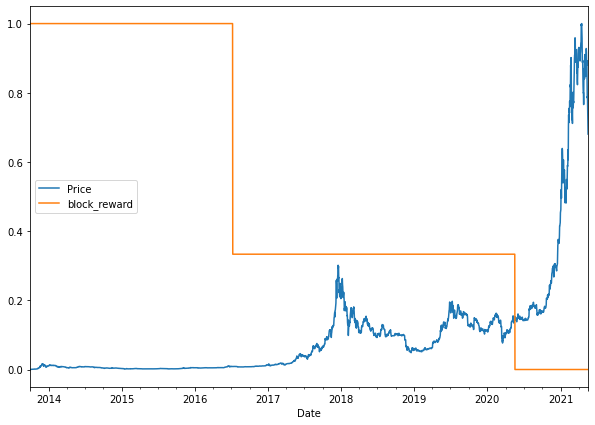

In [ ]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                                                       columns=bitcoin_prices_block.columns,
                                                                       index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10,7));

## Making a windowed dataset with pandas

Previously, we've turned our univariate time series into windowed dataset using the helper functions above.

However, since we've got multivariate data, these functions won't work.

Not to worry, we can use the pandas.DataFrame.shift() method to window our multivariate data.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html

In [ ]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [ ]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


What we've done is created a way to window our dataset directly from a pandas dataframe.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [ ]:
# Create X (windows) and y (horizons) features , also dropping the price column becoz that is going to be our label/horizon -> also converting it to type float32 becoz we know tensorflow likes float32
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [ ]:
# Make train and test sets using indexing  (and not randomly splitting , becoz we dont want to leak(mix) our pseudo(future) data)
split_size = int(len(X) * 0.8)
X_train , y_train = X[:split_size] , y[:split_size]
X_test , y_test = X[split_size:] , y[split_size:]
len(X_train) , len(y_train) , len(X_test) , len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)

In [ ]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 13s - loss: 2900.7500

18/18 [==============================] - 1s 33ms/step - loss: 1146.3638 - val_loss: 2819.4360
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 424.1335

18/18 [==============================] - 0s 26ms/step - loss: 327.2915 - val_loss: 1360.0096
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 171.6694

18/18 [==============================] - 0s 26ms/step - loss: 205.1908 - val_loss: 1152.5286
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 248.5563

18/18 [==============================] - 0s 27ms/step - loss: 195.3176 - val_loss: 1053.1322
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 192.0086

18/18 [==============================] - 0s 27ms/step - loss: 188.2774 - val_loss: 1034.2616
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 143.1879

18/18 [==============================] - 0s 27ms/step - loss: 185.3756 - val_loss: 1021.7120
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 229.2309

18/18 [==============================] - 0s 26ms/step - loss: 178.8175 - val_loss: 1011.7961
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 155.7940

18/18 [==============================] - 0s 25ms/step - loss: 172.0113 - val_loss: 948.1403
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: 169.9841 - val_loss: 949.8150
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 181.2492

18/18 [==============================] - 0s 26ms/step - loss: 163.5524 - val_loss: 896.3879
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 176.5480

18/18 [==============================] - 0s 25ms/step - loss: 156.8420 - val_loss: 864.9476
Epoch 12/100
18/18 [==============================] - 0s 4ms/step - loss: 151.5548 - val_loss: 881.6794
Epoch 13/100
18/18 [==============================] - 0s 5ms/step - loss: 149.6978 - val_loss: 898.7101
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 158.7539

18/18 [==============================] - 0s 26ms/step - loss: 143.4640 - val_loss: 850.5274
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 143.4003

18/18 [==============================] - 0s 25ms/step - loss: 141.4557 - val_loss: 781.7601
Epoch 16/100
18/18 [==============================] - 0s 5ms/step - loss: 135.8207 - val_loss: 796.0139
Epoch 17/100
18/18 [==============================] - 0s 4ms/step - loss: 133.4804 - val_loss: 820.1935
Epoch 18/100
18/18 [==============================] - 0s 5ms/step - loss: 134.5255 - val_loss: 788.8154
Epoch 19/100
18/18 [==============================] - 0s 4ms/step - loss: 128.5248 - val_loss: 810.6523
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 143.1578

18/18 [==============================] - 0s 25ms/step - loss: 127.7750 - val_loss: 685.5745
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 156.6449

18/18 [==============================] - 0s 25ms/step - loss: 126.1137 - val_loss: 672.9167
Epoch 22/100
18/18 [==============================] - 0s 5ms/step - loss: 122.3978 - val_loss: 680.1476
Epoch 23/100
18/18 [==============================] - 0s 4ms/step - loss: 126.6621 - val_loss: 689.1493
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 129.5251

18/18 [==============================] - 0s 25ms/step - loss: 120.9968 - val_loss: 643.6229
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 124.8425

18/18 [==============================] - 0s 26ms/step - loss: 117.9522 - val_loss: 638.1289
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 112.2664

18/18 [==============================] - 0s 28ms/step - loss: 117.2460 - val_loss: 629.2224
Epoch 27/100
12/18 [===================>..........] - ETA: 0s - loss: 121.9437

18/18 [==============================] - 1s 61ms/step - loss: 117.7540 - val_loss: 622.7341
Epoch 28/100
15/18 [========================>.....] - ETA: 0s - loss: 112.4461

18/18 [==============================] - 1s 38ms/step - loss: 114.1425 - val_loss: 616.4722
Epoch 29/100
18/18 [==============================] - 0s 6ms/step - loss: 113.4148 - val_loss: 625.2715
Epoch 30/100
13/18 [====================>.........] - ETA: 0s - loss: 116.2625

18/18 [==============================] - 0s 27ms/step - loss: 118.2537 - val_loss: 607.2587
Epoch 31/100
 1/18 [>.............................] - ETA: 0s - loss: 122.3483

18/18 [==============================] - 0s 25ms/step - loss: 112.7579 - val_loss: 602.1059
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 105.3355

18/18 [==============================] - 0s 26ms/step - loss: 112.4606 - val_loss: 598.8389
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 113.7343 - val_loss: 647.5156
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 138.1623

18/18 [==============================] - 0s 26ms/step - loss: 112.0953 - val_loss: 598.7690
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 101.8761

18/18 [==============================] - 0s 25ms/step - loss: 110.7969 - val_loss: 593.4286
Epoch 36/100
 1/18 [>.............................] - ETA: 0s - loss: 155.5443

18/18 [==============================] - 0s 27ms/step - loss: 115.3696 - val_loss: 589.2696
Epoch 37/100
18/18 [==============================] - 0s 6ms/step - loss: 112.0948 - val_loss: 594.2147
Epoch 38/100
18/18 [==============================] - 0s 5ms/step - loss: 111.9513 - val_loss: 599.1663
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 125.8185

18/18 [==============================] - 0s 26ms/step - loss: 109.4598 - val_loss: 582.9838
Epoch 40/100
18/18 [==============================] - 0s 4ms/step - loss: 109.1597 - val_loss: 587.2722
Epoch 41/100
18/18 [==============================] - 0s 4ms/step - loss: 109.7308 - val_loss: 594.7504
Epoch 42/100
18/18 [==============================] - 0s 5ms/step - loss: 112.6608 - val_loss: 653.7652
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 116.4225 - val_loss: 673.5182
Epoch 44/100
18/18 [==============================] - 0s 5ms/step - loss: 121.7559 - val_loss: 640.3804
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 113.8277 - val_loss: 622.5372
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 83.6223

18/18 [==============================] - 0s 25ms/step - loss: 112.5485 - val_loss: 579.7705
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 108.5608 - val_loss: 604.4106
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 109.0792 - val_loss: 608.4520
Epoch 49/100
18/18 [==============================] - 0s 4ms/step - loss: 110.1903 - val_loss: 609.5057
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 114.7422 - val_loss: 614.0402
Epoch 51/100
18/18 [==============================] - 0s 5ms/step - loss: 110.3563 - val_loss: 583.6757
Epoch 52/100
18/18 [==============================] - 0s 4ms/step - loss: 110.3854 - val_loss: 583.1786
Epoch 53/100
18/18 [==============================] - 0s 4ms/step - loss: 112.3639 - val_loss: 627.0584
Epoch 54/100
18/18 [==============================] - 0s 4ms/step - loss: 115.7788 - val_loss: 608.7925
Epoch 55/100
 1/18 [>.............................] - ETA: 0s - loss: 129.90

18/18 [==============================] - 0s 25ms/step - loss: 110.9904 - val_loss: 573.1021
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 107.2751 - val_loss: 774.0521
Epoch 57/100
 1/18 [>.............................] - ETA: 0s - loss: 115.4964

18/18 [==============================] - 0s 26ms/step - loss: 116.7355 - val_loss: 572.2512
Epoch 58/100
18/18 [==============================] - 0s 4ms/step - loss: 111.8184 - val_loss: 592.0024
Epoch 59/100
18/18 [==============================] - 0s 4ms/step - loss: 109.3118 - val_loss: 644.9183
Epoch 60/100
18/18 [==============================] - 0s 5ms/step - loss: 113.9585 - val_loss: 644.6923
Epoch 61/100
 1/18 [>.............................] - ETA: 0s - loss: 143.0909

18/18 [==============================] - 0s 25ms/step - loss: 109.7609 - val_loss: 569.6593
Epoch 62/100
18/18 [==============================] - 0s 5ms/step - loss: 107.0570 - val_loss: 571.1998
Epoch 63/100
18/18 [==============================] - 0s 4ms/step - loss: 110.3551 - val_loss: 613.4555
Epoch 64/100
18/18 [==============================] - 0s 4ms/step - loss: 109.1603 - val_loss: 578.1403
Epoch 65/100
 1/18 [>.............................] - ETA: 0s - loss: 128.0754

18/18 [==============================] - 0s 25ms/step - loss: 107.9372 - val_loss: 567.1519
Epoch 66/100
18/18 [==============================] - 0s 4ms/step - loss: 107.2065 - val_loss: 568.2465
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 106.1974 - val_loss: 632.5599
Epoch 68/100
18/18 [==============================] - 0s 4ms/step - loss: 114.7038 - val_loss: 732.7360
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 127.2748 - val_loss: 649.5794
Epoch 70/100
18/18 [==============================] - 0s 4ms/step - loss: 126.7944 - val_loss: 567.7445
Epoch 71/100
18/18 [==============================] - 0s 4ms/step - loss: 112.6304 - val_loss: 595.0685
Epoch 72/100
18/18 [==============================] - 0s 4ms/step - loss: 107.3365 - val_loss: 595.8083
Epoch 73/100
18/18 [==============================] - 0s 5ms/step - loss: 112.8394 - val_loss: 602.4163
Epoch 74/100
 1/18 [>.............................] - ETA: 0s - loss: 167.20

18/18 [==============================] - 0s 24ms/step - loss: 107.2115 - val_loss: 566.5330
Epoch 75/100
 1/18 [>.............................] - ETA: 0s - loss: 124.3790

18/18 [==============================] - 0s 26ms/step - loss: 107.7044 - val_loss: 565.2209
Epoch 76/100
18/18 [==============================] - 0s 4ms/step - loss: 108.9337 - val_loss: 569.1793
Epoch 77/100
18/18 [==============================] - 0s 4ms/step - loss: 107.3704 - val_loss: 568.4658
Epoch 78/100
18/18 [==============================] - 0s 4ms/step - loss: 108.3032 - val_loss: 575.0488
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 107.1320 - val_loss: 584.4702
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 107.6417 - val_loss: 583.9378
Epoch 81/100
 1/18 [>.............................] - ETA: 0s - loss: 96.4227

18/18 [==============================] - 0s 25ms/step - loss: 105.8559 - val_loss: 564.6758
Epoch 82/100
18/18 [==============================] - 0s 5ms/step - loss: 115.7178 - val_loss: 565.0941
Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 112.3506 - val_loss: 666.4897
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 112.3655 - val_loss: 587.9866
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 107.4191 - val_loss: 578.4849
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 107.1716 - val_loss: 569.9962
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 107.3540 - val_loss: 576.5778
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 107.0201 - val_loss: 573.7773
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 106.7484 - val_loss: 570.9691
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 10

18/18 [==============================] - 1s 36ms/step - loss: 106.8430 - val_loss: 563.8170
Epoch 96/100
18/18 [==============================] - 0s 7ms/step - loss: 115.5139 - val_loss: 694.3423
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 111.2128 - val_loss: 565.4122
Epoch 98/100
18/18 [==============================] - 0s 5ms/step - loss: 106.3981 - val_loss: 576.1055
Epoch 99/100
 1/18 [>.............................] - ETA: 0s - loss: 150.8986

18/18 [==============================] - 0s 25ms/step - loss: 107.2403 - val_loss: 563.1282
Epoch 100/100
18/18 [==============================] - 0s 4ms/step - loss: 118.8052 - val_loss: 659.9379


In [ ]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 659.9380


659.93798828125

In [ ]:
# Load in and evaluate best performing model
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 563.1282


563.1282348632812

In [ ]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8853.865, 8769.282, 9040.972, 8793.74 , 8731.26 , 8742.758,
       8689.527, 8516.611, 8462.425, 8531.272], dtype=float32)>

In [ ]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 563.12823,
 'mse': 1153466.0,
 'rmse': 1073.9954,
 'mape': 2.5144403,
 'mase': 0.9892603}

In [ ]:
model_1_results

{'mae': 566.12665,
 'mse': 1163180.2,
 'rmse': 1078.5083,
 'mape': 2.5398948,
 'mase': 0.9945277}

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

## Model 7: N-BEATS algorithm

Let's now try build the biggest time series forecasting model we've built so far.

More specifically, we're going to be replicating the algorithm in Figure 1 from the following paper: https://arxiv.org/pdf/1905.10437.pdf

### Building and testing the N-BEATS block layer

Because the N-BEATS block layer doesn't exist in TensorFlow, we've got to create it.

To create custom layers and models in TensorFlow we can use subclassing: https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [ ]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers , each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)  # means x is gonna continually get updated as it passes through each layer in the FC Stack
    theta = self.theta_layer(x)
    # Output the backcast and the forecast from theta
    backcast , forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast


Let's test our NBeatsBlock class.

To do we'll make some dummy inputs and outputs.

In [ ]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,  # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
# Create dummy inputs (have to be the same size as the input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0)  # input shape to to the model has to reflect dense
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.21040699  0.9528678  -0.01094876 -0.32186446 -0.01347256 -0.22149418
 -0.2607966 ]
Forecast: -0.5451505184173584


### Preparing data for the N-BEATS algorithm using `tf.data`

To make our input data load as fast as possible we're going to be adhering to the performant data pipeline steps in the tf.data guide: https://www.tensorflow.org/guide/data_performance

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create N-BEATS data inputs (N-BEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [ ]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

The N-BEATS algorithm has a fair few number of parameters, many of them can be found in Table 18: https://arxiv.org/pdf/1905.10437.pdf

In [ ]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE , THETA_SIZE

(7, 8)

### Getting ready for residual connections

Before we can craft our N-BEATS model, we need two layers for the residual connections (subtract and add).

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture (section 3.2 of N-BEATS paper).

In [ ]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1,tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [ ]:
tensor_1, tensor_2

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>)

### Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use for loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default setting as per section 5.2 of N-BEATS paper
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:

* Early Stopping - because the model will be training for so long, we'll stop it early if it stops improving
* Reduce LR on Plateau - if a model stops improving, try lowering the learning to reduce the amount it updates its weights each time (take smaller steps towards best performance)

In [ ]:
%%time

tf.random.set_seed(42)

# 1. Setup and instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stack
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already created in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass in the residuals

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBEATS")

# 8. Compile model with MAE loss
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            patience=100,
                                                            verbose=1)])


Epoch 760: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1061: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1161: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 4min 9s, sys: 7.14 s, total: 4min 16s
Wall time: 4min 51s


In [ ]:
# Evaluate the N-Beats model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 20ms/step - loss: 572.2633


572.2633056640625

In [ ]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8821.047, 8785.437, 9063.038, 8757.654, 8772.074, 8747.952,
       8666.568, 8504.063, 8483.983, 8534.83 ], dtype=float32)>

In [ ]:
# Evaluate N-BEATS model preds
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 572.2633,
 'mse': 1156559.0,
 'rmse': 1075.4343,
 'mape': 2.6463149,
 'mase': 1.0053082}

In [ ]:
model_1_results

{'mae': 566.12665,
 'mse': 1163180.2,
 'rmse': 1078.5083,
 'mape': 2.5398948,
 'mase': 0.9945277}

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

we can see that even with all of those special layers and hand-crafted network, it looks like the N-BEATS model doesn't perform as well as model_1 or the original naive forecast.

This goes to show the power of smaller networks as well as the fact not all larger models are better suited for a certain type of data.

### Plotting the N-BEATS architecture we've created

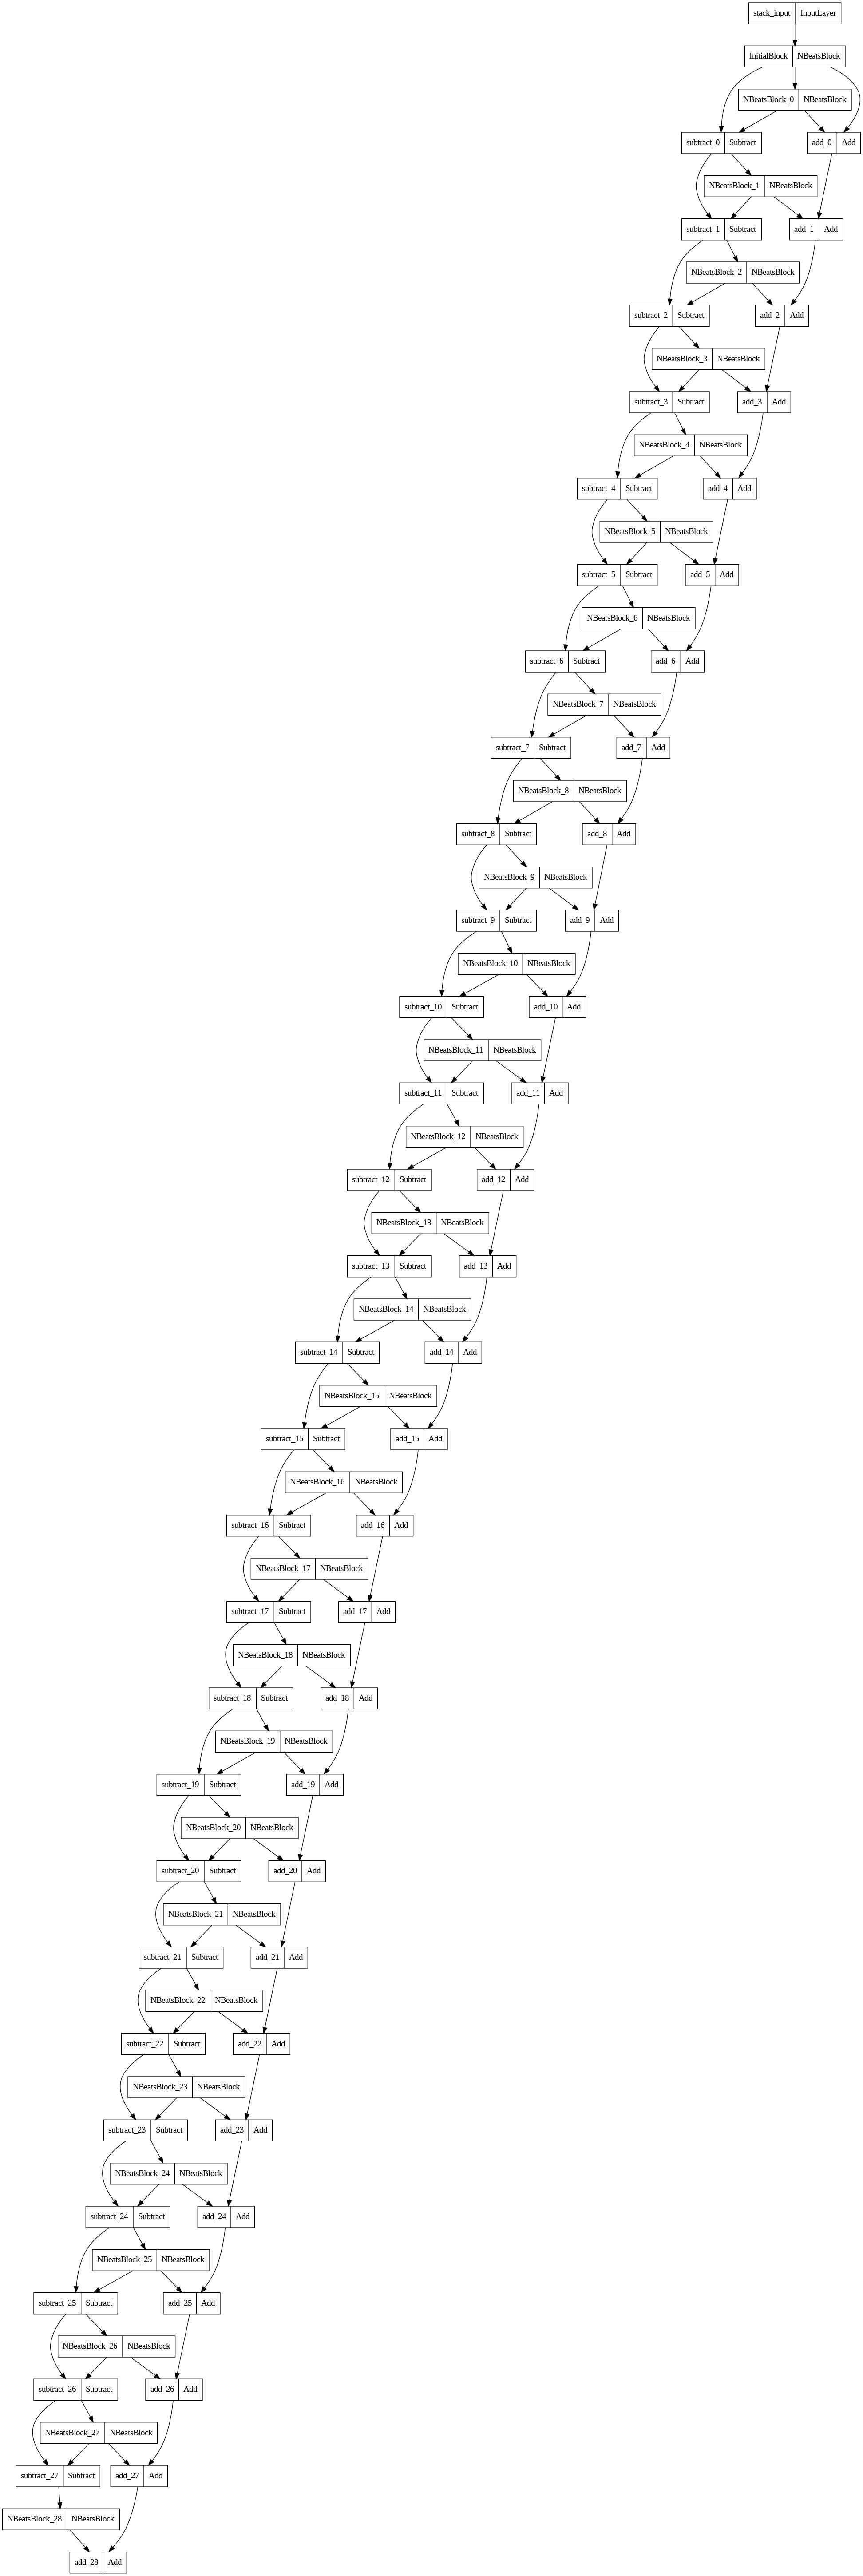

In [ ]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8: Creating an ensemble (stacking different models together)

An ensemble leverages the wisdom of the crowd effect.

It combines many different models to predict a common goal.

In [ ]:
HORIZON , WINDOW_SIZE

(1, 7)

### Constructing and fitting an ensemble of models (using different loss functions)

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize dense layers with normal distribution for estimating prediction intervals later on
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # Fit the current model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

In [ ]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 855: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 955: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 360: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 460: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 119: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 458: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 720: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 820: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 596: ReduceLROnPl

In [ ]:
len(ensemble_models)

15

In [ ]:
ensemble_models

### Make predictions with our ensemble model

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 35ms/step
CPU times: user 635 ms, sys: 30.4 ms, total: 665 ms
Wall time: 802 ms


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8789.098 ,  8773.598 ,  9062.33  , ..., 49914.266 , 48568.83  ,
        46037.15  ],
       [ 8752.89  ,  8771.785 ,  9006.329 , ..., 49888.87  , 48093.1   ,
        46357.1   ],
       [ 8828.857 ,  8823.41  ,  9079.967 , ..., 50269.484 , 48548.957 ,
        46140.402 ],
       ...,
       [ 8760.414 ,  8708.046 ,  9112.611 , ..., 49956.81  , 48530.965 ,
        46007.13  ],
       [ 8799.31  ,  8837.003 ,  9089.2295, ..., 50689.56  , 47955.36  ,
        46076.92  ],
       [ 8796.255 ,  8761.2   ,  9046.984 , ..., 49846.844 , 48022.742 ,
        45761.168 ]], dtype=float32)>

In [ ]:
ensemble_preds

<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8789.098 ,  8773.598 ,  9062.33  , ..., 49914.266 , 48568.83  ,
        46037.15  ],
       [ 8752.89  ,  8771.785 ,  9006.329 , ..., 49888.87  , 48093.1   ,
        46357.1   ],
       [ 8828.857 ,  8823.41  ,  9079.967 , ..., 50269.484 , 48548.957 ,
        46140.402 ],
       ...,
       [ 8760.414 ,  8708.046 ,  9112.611 , ..., 49956.81  , 48530.965 ,
        46007.13  ],
       [ 8799.31  ,  8837.003 ,  9089.2295, ..., 50689.56  , 47955.36  ,
        46076.92  ],
       [ 8796.255 ,  8761.2   ,  9046.984 , ..., 49846.844 , 48022.742 ,
        45761.168 ]], dtype=float32)>

In [ ]:
y_test

Date
2019-11-10     8798.042055
2019-11-11     9081.186878
2019-11-12     8711.534339
2019-11-13     8760.892718
2019-11-14     8749.520591
                  ...     
2021-05-14    49764.132082
2021-05-15    50032.693137
2021-05-16    47885.625255
2021-05-17    45604.615754
2021-05-18    43144.471291
Name: Price, Length: 556, dtype: float64

Our ensemble preds come out in multiple dimensions but to combine into point predictions we can leverage the mean of all of the predictions or the median - https://machinelearningmastery.com/combine-predictions-for-ensemble-learning/

In [ ]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8790.226, 8772.159, 9059.144, 8717.563, 8731.053, 8729.132,
       8653.519, 8475.488, 8450.629, 8513.414], dtype=float32)>

In [ ]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median[:10]

array([8799.31 , 8771.785, 9061.308, 8709.202, 8746.295, 8716.124,
       8654.827, 8476.46 , 8450.291, 8515.305], dtype=float32)

In [ ]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_mean)
ensemble_results

{'mae': 567.2391,
 'mse': 1150659.5,
 'rmse': 1072.688,
 'mape': 2.554766,
 'mase': 0.99648196}

In [ ]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_median)
ensemble_results

{'mae': 568.04364,
 'mse': 1152919.0,
 'rmse': 1073.7406,
 'mape': 2.555963,
 'mase': 0.99789536}

### Plotting the prediction intervals (uncertainity estimates) of our ensemble

So far we've been making point predictions with our models.

E.g. horizon = 1, our model predicts tomorrow's price of Bitcoin will be $50,000USD

Wouldn't it be helpful if we knew a range of where that prediction came from?

Instead of 50,000 USD on the dot, how about 48,000 to 52,000 USD?

One way to get the 95% confidence prediction intervals for a deep learning model is the bootstrap method:

1. Take the predictions from a number of randomly initialzed models (we've got this thanks to our ensemble models)
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96 (assuming the distribution is Gaussian/Normal, 95% of observations fall within 1.96 standard deviations of the mean)
4. To the get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)



In [ ]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions from a number of randomly initialized models

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower,upper = preds_mean - interval , preds_mean + interval

  return lower,upper

In [ ]:
# Get the upper and lower bounds of the 95% percent prediction interval
lower,upper = get_upper_lower(preds=ensemble_preds)
lower,upper

(<tf.Tensor: shape=(556,), dtype=float32, numpy=
 array([ 8733.939 ,  8708.089 ,  8992.595 ,  8655.306 ,  8637.461 ,
         8615.255 ,  8594.191 ,  8406.945 ,  8389.816 ,  8480.383 ,
         8148.8755,  8030.244 ,  7981.259 ,  7566.7505,  7229.8335,
         7240.8877,  7020.604 ,  7109.1714,  7051.5747,  7409.0396,
         7358.7993,  7644.8486,  7516.9414,  7322.359 ,  7248.284 ,
         7272.3037,  7137.2993,  7338.488 ,  7467.485 ,  7479.012 ,
         7487.9707,  7287.7495,  7180.0103,  7144.29  ,  7134.362 ,
         7182.9937,  7034.6865,  7049.7695,  6825.404 ,  6528.4824,
         7239.888 ,  7059.3604,  6987.884 ,  7182.8657,  7147.403 ,
         7060.218 ,  7168.3516,  7175.306 ,  7125.0464,  7175.262 ,
         7263.4404,  7336.446 ,  7202.076 ,  7119.586 ,  7127.677 ,
         6908.8203,  7198.023 ,  7288.6733,  7283.6562,  7632.9985,
         7946.252 ,  8075.7046,  7781.273 ,  7998.0586,  8042.346 ,
         8086.2485,  8055.9185,  8629.214 ,  8824.191 ,  8686.966 ,

In [ ]:
X_test.index[:10]

DatetimeIndex(['2019-11-10', '2019-11-11', '2019-11-12', '2019-11-13',
               '2019-11-14', '2019-11-15', '2019-11-16', '2019-11-17',
               '2019-11-18', '2019-11-19'],
              dtype='datetime64[ns]', name='Date', freq=None)

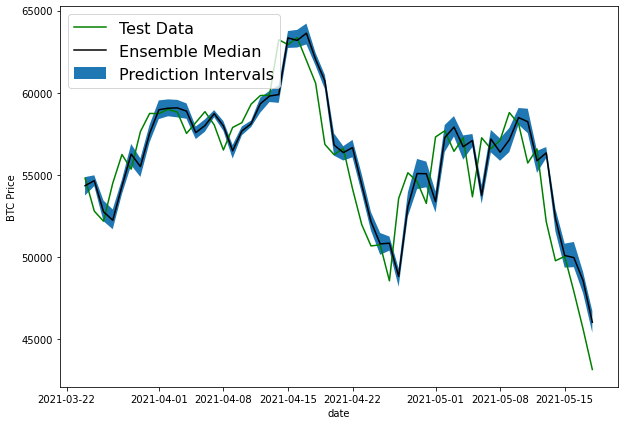

In [ ]:
# Get the median/mean values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall betweeen)
offset = 500
plt.figure(figsize=(10,7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("date")
plt.ylabel("BTC Price")
# To plot the upper and lower bounds, lets use fill_between : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:] , label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=16);

So far all of our models predictions have been lagging behind the test data...

As is they're replicating what the naive model does and just predict the previous timestep as the next timestep.

> Note: These prediction intervals are estimates themselves. And they have been created with the assumption that our model's data is from a normal distribution.

Aside: two types of uncertainty (coconut and subway)

Uncertainty estimates in machine learning seek out to qualitatively and quantitatively answer the questions:

1. What can my model know? (with perfect data, what's possible for a model to learn?)
2. What doesn't my model know? (what can a model never predict? Or would it helpful if a model could tell you that when it's making a prediction, it doesn't actually know if it's right or not?)
There are two major types of uncertainty in machine learning can be seen quite often :

* **Aleatoric uncertainty** - this type of uncertainty cannot be reduced and it is often referred as "data" uncertainty or "subway" uncertainty
* **Epistemic uncertainty** - this type of uncertainty can be reduced, it also referred to as "model" or "coconut" uncertainty


## Model 9: Train a model on the full historical data to make predictions into the future

So far all of our models have predicted on the test dataset, however, this is only a pseudofuture.

Let's now build a model which is capable of predicting into the future!

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


In [ ]:
# Train model on entire data to make predictions for the next day
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()
# Get labels
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

len(X_all) , len(y_all)

(2780, 2780)

In [ ]:
X_all[:10] , y_all[:10]

(array([[121.795  , 120.65533, 121.33866, 118.67466, 108.58483, 125.455  ,
         123.65499],
        [123.033  , 121.795  , 120.65533, 121.33866, 118.67466, 108.58483,
         125.455  ],
        [124.049  , 123.033  , 121.795  , 120.65533, 121.33866, 118.67466,
         108.58483],
        [125.96116, 124.049  , 123.033  , 121.795  , 120.65533, 121.33866,
         118.67466],
        [125.27966, 125.96116, 124.049  , 123.033  , 121.795  , 120.65533,
         121.33866],
        [125.9275 , 125.27966, 125.96116, 124.049  , 123.033  , 121.795  ,
         120.65533],
        [126.38333, 125.9275 , 125.27966, 125.96116, 124.049  , 123.033  ,
         121.795  ],
        [135.24199, 126.38333, 125.9275 , 125.27966, 125.96116, 124.049  ,
         123.033  ],
        [133.20333, 135.24199, 126.38333, 125.9275 , 125.27966, 125.96116,
         124.049  ],
        [142.76333, 133.20333, 135.24199, 126.38333, 125.9275 , 125.27966,
         125.96116]]),
 array([123.033  , 124.049  , 125.9611

## Model 10: Why forecasting is bad !!

In [ ]:
# Let's introduce a turkey problem to our BTC data (price of BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [ ]:
# Manufacture an extra price on the end (to showcase our Turkey problem)
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [ ]:
# Get the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

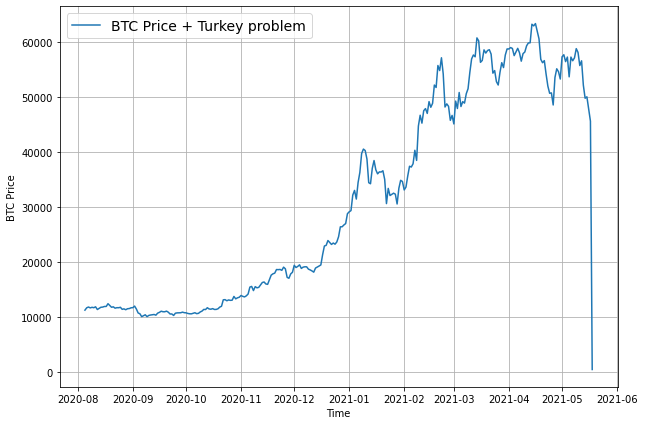

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC Price + Turkey problem",
                 start=2500
                 )

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


### Build a turkey model (model to predict on turkey data)

In [ ]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "model_10_turkey_model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 batch_size=128,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

In [ ]:
# Evaluate model on test data
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 700.0505


700.0504760742188

In [ ]:
# Load best performing turkey model and evaluate on test data
turkey_model = tf.keras.models.load_model("model_experiments/model_10_turkey_model")
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 645.3897


645.3897094726562

In [ ]:
# Make predictions with turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8874.778, 8769.045, 9028.027, 8800.485, 8731.218, 8752.671,
       8691.89 , 8515.35 , 8471.926, 8526.186], dtype=float32)>

In [ ]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

{'mae': 17126.389,
 'mse': 614234000.0,
 'rmse': 23709.146,
 'mape': 121.32235,
 'mase': 26.50314}

In [ ]:
model_1_results

{'mae': 566.12665,
 'mse': 1163180.2,
 'rmse': 1078.5083,
 'mape': 2.5398948,
 'mase': 0.9945277}

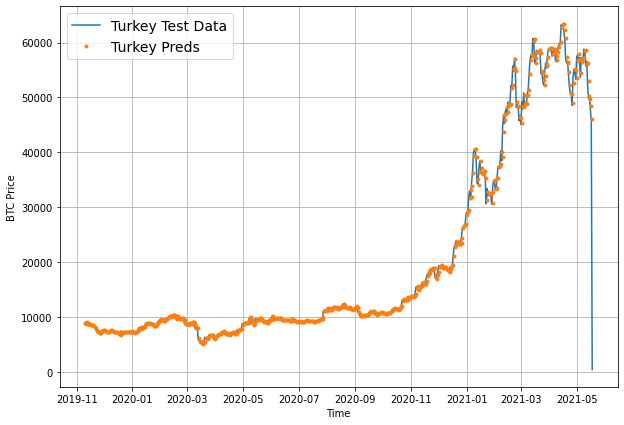

In [ ]:
plt.figure(figsize=(10, 7))
offset=0
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format="-",
                 label="Turkey Test Data",
                 start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 label="Turkey Preds",
                 start=offset);

## Compare models

In [ ]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_7_NBEATS": model_7_results,
                              "model_8_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,567.980225,1.147547e+06,1071.236206,2.516525,0.999570
model_1_dense_w7_h1,566.126648,1.163180e+06,1078.508301,2.539895,0.994528
model_2_dense_w30_h1,614.963623,1.314870e+06,1146.677612,2.753809,1.074962
model_3_dense_w30_h7,1242.759521,5.476694e+06,1430.548828,5.622880,2.211421
model_4_CONV1D,569.617493,1.183238e+06,1087.767578,2.550935,1.000660
model_5_LSTM,589.552856,1.249899e+06,1117.988770,2.649061,1.035681
model_6_multivariate,563.128235,1.153466e+06,1073.995361,2.514440,0.989260
model_7_NBEATS,572.263306,1.156559e+06,1075.434326,2.646315,1.005308
model_8_ensemble,568.043640,1.152919e+06,1073.740601,2.555963,0.997895
model_10_turkey,17126.388672,6.142340e+08,23709.146484,121.322350,26.503139


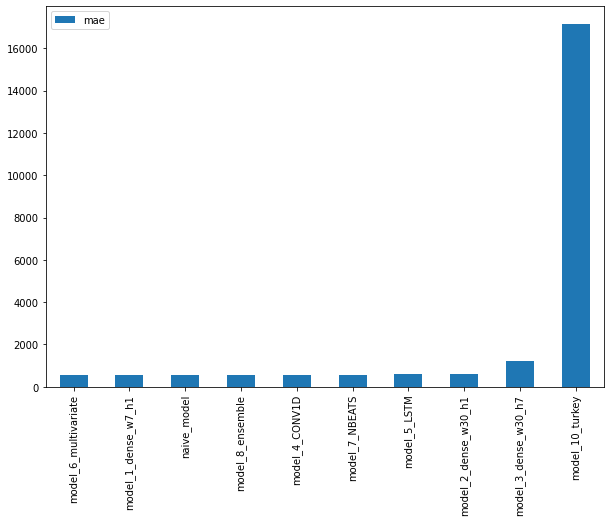

In [ ]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10,7), kind="bar");